In [244]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.integrate import odeint

In [245]:
from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r
from math import comb

class DynamicsBasis():
    
    def __init__(self, degree, X, t):  
#         super().__init__(degree = degree)
        self.m_samples = X.shape[0]
        self.dim = X.shape[1]
        self.degree = degree
        self.n_basis = comb(self.dim + self.degree, self.degree)
        self.t = t
        self.include_bias = True
        self.X = X
        
    @property
    def multi_index(self):
        
        comb = combinations_w_r
        start = int(not self.include_bias)
        combinations = chain.from_iterable(comb(range(self.dim), i) for i in range(start, self.degree + 1))
                                   
        
        return np.vstack([np.bincount(c, minlength=self.dim) for c in combinations])
                                    
    @property
    def basis_names(self, input_dims = None):
        
        powers = self.multi_index
        if input_dims is None:
            input_dims = ['x%d' % i for i in range(powers.shape[1])]
        basis_names = []
        for row in powers:
            inds = np.where(row)[0]
            if len(inds):
                name = " ".join("%s^%d" % (input_dims[ind], exp)
                                if exp != 1 else input_dims[ind]
                                for ind, exp in zip(inds, row[inds]))
            else:
                name = "1"
            basis_names.append(name)
            
        return basis_names
    
    def phi_matrix(self, X = None):
        
        if X is None:
            X = self.X
            
        powers = self.multi_index
        
        Phi = np.zeros((X.shape[0], self.n_basis))
        
        for basis in range(self.n_basis):
        
            indices = basis
            col_indices_nd = np.zeros((X.shape[0],2))
            col_indices_nd[:,0] = np.arange(X.shape[0])
            col_indices_nd[:,1] = indices
            col_indices_nd = col_indices_nd.astype('int')
            updates = np.prod(np.power(X, np.tile([powers[basis,:]],(X.shape[0],1))), axis = 1)
            #This should be equivalent to tensorflow tf.tensor_scatter_nd_update
            Phi[np.ix_(col_indices_nd[:,0], col_indices_nd[:,1])] = updates.reshape(X.shape[0],1)
            
        return Phi
        
    def psi_matrix(self, X=None, t=None):
        
        if X is None:
            X = self.X
            
        if t is None:
            t = self.t
            
        self.m_samples = X.shape[0]
        
        Dt = t[1] - t[0]
        
        T = Dt * np.tril(np.ones(self.m_samples))
        
        Phi = self.phi_matrix(X)
                
        return np.matmul(T, Phi)

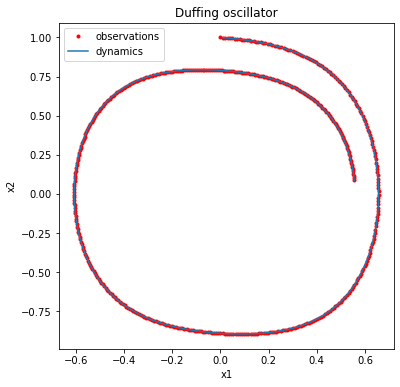

In [246]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def duffing(x, t, gamma=0.1, kappa=1, epsilon=5):
    return [
            x[1],
            -gamma * x[1] - kappa * x[0] - epsilon * x[0] ** 3
            ]

gamma=0.1
kappa=1
epsilon=5

####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 5 # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
t_span_half = 0.5 * (t_span[0:-2] + t_span[1:-1])

x0 = [0, 1]
X = odeint(duffing, x0, t_span)
X_half = odeint(duffing, x0, np.insert(t_span_half,0,0))
X_half = X_half[1:]# For midpoint rule

x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -gamma * x2 - kappa * x1 - epsilon * x1 ** 3

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Duffing oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

In [247]:
X_data = X
X_data_tilde = X[1:,:] - X[0,:]
t_data = t
t_data_tilde = t[1:]
dX_data = dX
degree = 3

In [248]:
dynamics = DynamicsBasis(degree, X, t)

In [252]:
Phi = dynamics.phi_matrix()
Psi = dynamics.psi_matrix(X_half, t_span_half)

In [253]:
Y_data = X_data_tilde
dY_data = dX_data

In [254]:
## LEAST SQUARES SOLUTION

XI_diff = np.linalg.lstsq(Phi,dY_data)[0]
XI_int = np.linalg.lstsq(Psi,Y_data)[0]

<ipython-input-254-2667b1d6685e>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  XI_diff = np.linalg.lstsq(Phi,dY_data)[0]


LinAlgError: Incompatible dimensions

In [234]:
XI_diff[np.abs(XI_diff) < 1e-8] = 0
print(XI_diff)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.  -0.1]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.  -5. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]]


In [237]:
XI_int[np.abs(XI_int) < 1e-8] = 0
print(XI_int)

[[ 1.00048347 -0.09504109]
 [ 0.         -1.00104881]
 [ 1.00048329 -0.09501235]
 [ 0.          0.07505824]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.02500712 -5.00157059]
 [ 0.          0.07504323]
 [ 0.          0.        ]
 [ 0.          0.        ]]


In [255]:
X_half.shape

(499, 2)

In [257]:
t_span_half.shape

(499,)